In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/kaggle-kl-div/kaggle_metric_utilities.py
/kaggle/input/kaggle-kl-div/kaggle_kl_div.py
/kaggle/input/hms-harmful-brain-activity-classification/sample_submission.csv
/kaggle/input/hms-harmful-brain-activity-classification/train.csv
/kaggle/input/hms-harmful-brain-activity-classification/test.csv
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2208063991.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1712674008.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3959808174.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2958965493.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3973731145.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3725914929.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/2917825580.parquet
/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/3497339021.parquet
/ka

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from sklearn import model_selection
import torchvision.transforms as transforms
import torchvision.io 
import librosa
from PIL import Image
import albumentations as alb
import torch.multiprocessing as mp
import warnings
warnings.filterwarnings('ignore')

from pytorch_lightning.callbacks import ModelCheckpoint, BackboneFinetuning, EarlyStopping

In [3]:
class Config:
    def __init__(self):
        self.optimizers ="adam"
        self.scheduler ="CosineAnnealingWarmRestarts"
        self.min_lr = 1e-6
        self.T_0 = 25

        self.use_aug = True
        self.num_classes = 6
        self.batch_size = 88
        self.epochs = 10
        self.PRECISION = 16
        self.PATIENCE = 20
        self.seed = 20
        self.pretrained = False
        self.weight_decay = 1e-2
        self.use_mixup = False
        self.mixup_alpha = 0.1
        self.num_channels = 8
        self.data_root = "/kaggle/input/hms-harmful-brain-activity-classification/"
        self.raw_eeg_path = "/kaggle/input/brain-eegs/eegs.npy"
        self.cols_interest = ['Fp1', 'C3', 'F7', 'T5', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
        self.LR = 8e-3
        self.processed_train = None
        self.output_dir = '/kaggle/working/exp30_augv2_8ch_mixup_onlyk3711_aug_32sp'
        self.trn_folds = [0, 1, 2, 3, 4]
        
Config = Config()

In [4]:
df = pd.read_csv(f'{Config.data_root}train.csv')
df.shape

(106800, 15)

<h2>Classes distribution

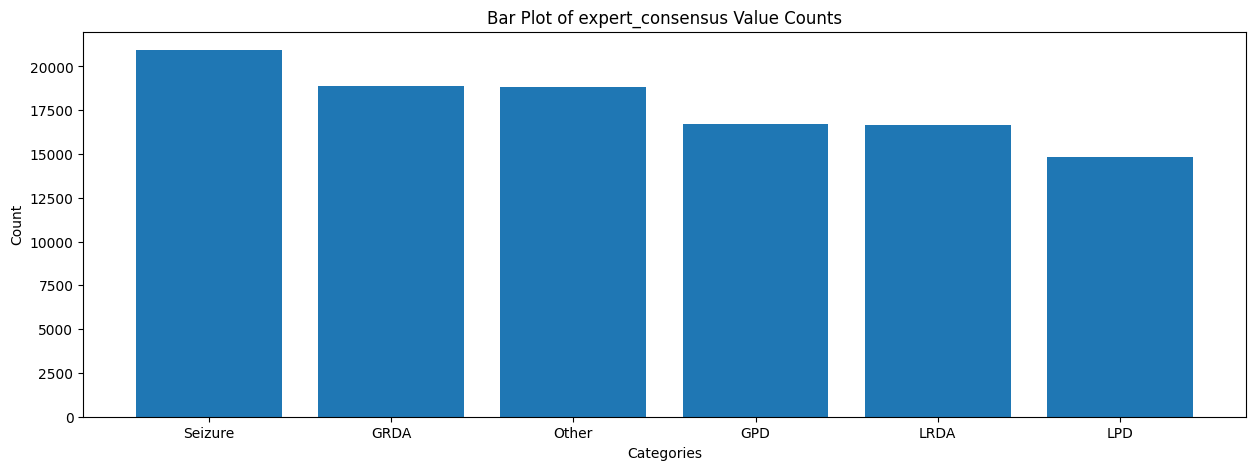

In [5]:
plt.figure(figsize =(15,5))
categories = df['expert_consensus'].value_counts().index
counts = df['expert_consensus'].value_counts()
plt.bar(categories, counts)
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Bar Plot of expert_consensus Value Counts')
plt.show()

In [6]:
df[df['eeg_id']==1000913311]

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
9529  1000913311           0                       0.0       175871552   

      spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
9529                   0                               0.0  3905268514   

      patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
9529       59743            Other             0         0         0   

      lrda_vote  grda_vote  other_vote  
9529          0          0           2

In [7]:
unique_eeg_samples = df['eeg_id'].unique()
print("Unique EEG samples = ", len(unique_eeg_samples))

Unique EEG samples =  17089


<h2>Reading EEG Signals

In [8]:
pqt = pd.read_parquet('/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/1000913311.parquet')


In [9]:
pqt

Fp1          F3          C3          P3          F7          T3  \
0    -105.849998  -89.230003  -79.459999  -49.230000  -99.730003  -87.769997   
1     -85.470001  -75.070000  -60.259998  -38.919998  -73.080002  -87.510002   
2       8.840000   34.849998   56.430000   67.970001   48.099998   25.350000   
3     -56.320000  -37.279999  -28.100000   -2.820000  -43.430000  -35.049999   
4    -110.139999 -104.519997  -96.879997  -70.250000 -111.660004 -114.430000   
...          ...         ...         ...         ...         ...         ...   
9995  -45.540001  -26.459999  -23.209999  -25.250000  -21.559999  -36.549999   
9996  -26.860001    4.350000    7.410000    7.830000    5.260000    7.750000   
9997 -133.759995 -111.190002 -119.180000 -105.760002 -130.039993 -104.059998   
9998  -78.889999  -59.660000  -60.770000  -59.810001  -63.020000  -60.020000   
9999    3.780000   36.009998   41.060001   34.389999   42.340000   37.709999   

             T5         O1         Fz         Cz         Pz         Fp2  \
0    -53.330002 -50.740002 -32.250000 -42.099998 -43.270000  -88.730003   
1    -39.680000 -35.630001 -76.839996 -62.740002 -43.040001  -68.629997   
2     80.250000  48.060001   6.720000  37.880001  61.000000   16.580000   
3      3.910000 -12.660000   8.650000   3.830000   4.180000  -51.900002   
4    -71.830002 -61.919998 -76.150002 -79.779999 -67.480003  -99.029999   
...         ...        ...        ...        ...        ...         ...   
9995  10.730000 -16.290001 -55.919998 -28.670000 -29.770000  -22.000000   
9996  50.130001   4.150000   1.720000  22.100000   7.150000   -6.820000   
9997 -68.290001 -86.480003 -57.130001 -68.830002 -95.839996 -107.540001   
9998 -20.690001 -42.820000 -68.669998 -54.740002 -62.810001  -52.869999   
9999  78.510002  28.770000   9.520000  38.189999  28.389999   22.920000   

             F4          C4         P4         F8         T4          T6  \
0    -74.410004  -92.459999 -58.930000 -75.739998 -59.470001    8.210000   
1    -61.689999  -69.320000 -35.790001 -58.900002 -41.660000  196.190002   
2     55.060001   45.020000  70.529999  47.820000  72.029999  -67.180000   
3    -21.889999  -41.330002 -11.580000 -27.040001 -11.730000  -91.000000   
4    -93.610001 -104.410004 -70.070000 -89.250000 -77.260002  155.729996   
...         ...         ...        ...        ...        ...         ...   
9995   3.710000    8.470000   0.480000   9.950000  33.959999  110.510002   
9996  38.070000   32.880001  21.990000  32.990002  60.209999 -156.949997   
9997 -86.449997  -94.099998 -97.050003 -86.339996 -68.040001  -14.880000   
9998 -34.099998  -31.500000 -37.810001 -32.259998 -10.870000  137.559998   
9999  69.970001   69.220001  53.160000  61.549999  90.910004 -115.550003   

              O2          EKG  
0      66.489998  1404.930054  
1     230.669998  3402.669922  
2    -171.309998 -3565.800049  
3     -81.190002 -1280.930054  
4     264.850006  4325.370117  
...          ...          ...  
9995   58.599998   301.239990  
9996 -275.929993 -4634.799805  
9997   66.440002  1667.800049  
9998  193.839996  2743.379883  
9999 -224.050003 -4185.600098  

[10000 rows x 20 columns]

<h2>Data Preprocessing


In [10]:
class DataProcessor:
    def __init__(self, df):
        self.df = df
        self.EEG_IDS = self.df['eeg_id'].unique()
        self.TARGETS = self.df.columns[-6:]
        self.TARS = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}
        self.TARS_INV = {x: y for y, x in self.TARS.items()}
        self.train = self.process_data()

    def process_data(self):
        train = self.df.groupby('eeg_id')[['patient_id']].agg('first')

        tmp = self.df.groupby('eeg_id')[self.TARGETS].agg('sum')
        for t in self.TARGETS:
            train[t] = tmp[t].values

        y_data = train[self.TARGETS].values
        y_data = y_data / y_data.sum(axis=1, keepdims=True)
        train[self.TARGETS] = y_data

        tmp = self.df.groupby('eeg_id')[['expert_consensus']].agg('first')
        train['target'] = tmp

        train = train.reset_index()
        train = train.loc[train.eeg_id.isin(self.EEG_IDS)]
        print('Train Data with unique eeg_id shape:', train.shape)

        return train

data_processor = DataProcessor(df)
train= data_processor.train

Train Data with unique eeg_id shape: (17089, 9)


In [11]:
train.head()

eeg_id  patient_id  seizure_vote  lpd_vote  gpd_vote  lrda_vote  grda_vote  \
0  568657       20654           0.0  0.000000      0.25   0.000000   0.166667   
1  582999       20230           0.0  0.857143      0.00   0.071429   0.000000   
2  642382        5955           0.0  0.000000      0.00   0.000000   0.000000   
3  751790       38549           0.0  0.000000      1.00   0.000000   0.000000   
4  778705       40955           0.0  0.000000      0.00   0.000000   0.000000   

   other_vote target  
0    0.583333  Other  
1    0.071429    LPD  
2    1.000000  Other  
3    0.000000    GPD  
4    1.000000  Other

In [12]:
%%time

CREATE_EEGS = True
df = pd.read_parquet(f'{Config.data_root}train_eegs/1000913311.parquet')
FEATS = df.columns
print(f'There are {len(FEATS)} raw eeg features')
print( list(FEATS) )

if Config.raw_eeg_path is not None:
    raw_eegs = np.load(Config.raw_eeg_path, allow_pickle=True).item()

There are 20 raw eeg features
['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']
CPU times: user 6.53 s, sys: 12.4 s, total: 19 s
Wall time: 1min 37s


<h2>Signal Augmentation

In [13]:
!pip install albumentations
!pip install torch_audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.2 MB/s eta 0:00:00
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21870 sha256=f70b051fc42f5abf2a84e7a9c9988931d704ebd5e475cb38ab3b0d0e7fbb10c2
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
Successfully built julius


In [14]:
from torch_audiomentations import Compose
import torch_audiomentations as t

def get_eeg_transforms(data='train'):
    if data == 'train':
        eeg_transform = t.Compose([
            t.AddColoredNoise(
                p=0.15,
                mode="per_channel",
                p_mode="per_channel",
                max_snr_in_db=15,
                sample_rate=200
            ),
            t.AddGaussianNoise(
                p=0.2,
                max_amplitude=0.5
            ),
            t.FrequencyMask(
                p=0.2,
                max_mask_percentage=0.1
            ),
            t.TimeMask(
                p=0.2,
                max_mask_percentage=0.1
            ),
        ])
    elif data == 'valid':
        eeg_transform = t.Compose([])  
    else:
        raise ValueError(f"Invalid data split: {data}")

    return eeg_transform

<h2>Model Building

In [15]:
import torch
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, in_channels=20, num_classes=6):
        super(EEGNet, self).__init__()

        # First convolution block
        self.conv1 = nn.Conv1d(in_channels, 32, kernel_size=64, stride=2, padding=16)
        self.bn1 = nn.BatchNorm1d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(0.5)

        # Second convolution block
        self.conv2 = nn.Conv1d(32, 64, kernel_size=16, stride=1, padding=8)
        self.bn2 = nn.BatchNorm1d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(0.5)

        # Third convolution block
        self.conv3 = nn.Conv1d(64, 128, kernel_size=8, stride=1, padding=4)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.dropout3 = nn.Dropout(0.5)

        # Fourth convolution block
        self.conv4 = nn.Conv1d(128, 256, kernel_size=4, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout4 = nn.Dropout(0.5)

        self.pool = nn.AdaptiveAvgPool1d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.relu_fc1 = nn.ReLU(inplace=True)
        self.dropout_fc1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.dropout4(x)

        x = self.pool(x).squeeze(-1)

        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout_fc1(x)

        x = self.fc2(x)

        return x


In [16]:
import gc
iot = torch.randn(2, Config.num_channels, 10000)#.cuda()
model = EEGNet(in_channels=Config.num_channels, num_classes=6)#.cuda()
output = model(iot)
print(output.shape)

del iot, model
gc.collect()

torch.Size([2, 6])


3653

<h2>Signal Preprocessing

In [17]:
from scipy.signal import cheby1, butter, lfilter


def quantize_data_linear(data, classes):
    min_val, max_val = np.min(data), np.max(data)
    bins = np.linspace(min_val, max_val, classes + 1)
    quantized = np.digitize(data, bins) - 1
    return quantized


def chebyshev_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4, rp=0.5):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = cheby1(order, rp, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data

class Dataset(torch.utils.data.Dataset):

    def __init__(self, data, eegs=None, augmentations=None, test=False): 
        self.data = data
        self.eegs = eegs
        self.augmentations = augmentations
        self.test = test
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]      
        data = self.eegs[row.eeg_id]

        data = np.clip(data, -1024, 1024)
        data = np.nan_to_num(data, nan=0) / 32.0
        
        data = chebyshev_lowpass_filter(data, order=4, rp=0.5)
        data = quantize_data_linear(data, 256)

        samples = torch.from_numpy(data).float()
        samples = samples.squeeze()

        samples = samples.permute(1, 0)
        if not self.test:
            label = row[TARGETS] 
            label = torch.tensor(label).float()  
            return samples, label
        else:
            return samples

<h2>Split the data

In [18]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train['fold'] = 0

for fold, (tr_idx, val_idx) in enumerate(skf.split(train, train['target'])):
    train.loc[val_idx, 'fold'] = fold

In [19]:
def get_fold_dls(df_train, df_valid):

    
    train_data = Dataset(
        df_train, 
        eegs=raw_eegs,
        augmentations =  get_eeg_transforms(data='valid'),
        test = False
    )
    
    val_data = Dataset(
        df_valid, 
        eegs=raw_eegs,
        augmentations = get_eeg_transforms(data='valid'),
        test = False
    )
    train_dataloader = DataLoader(train_data, batch_size=Config.batch_size , shuffle=True, num_workers = 2)    
    val_dataloader = DataLoader(val_data, batch_size=Config.batch_size, num_workers = 2)
    return train_dataloader, val_dataloader, train_data, val_data
 

In [20]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def get_optimizer_and_scheduler(lr, params):
    if Config.optimizers == 'adam':
        optimizer = optim.Adam(params, lr=lr, weight_decay=Config.weight_decay)
    elif Config.optimizers == 'nadam':
        optimizer = optim.Nadam(params, lr=lr, weight_decay=Config.weight_decay)
    elif Config.optimizers == 'adamW':
        optimizer = optim.AdamW(params, lr=lr, weight_decay=Config.weight_decay)
    elif Config.optimizers == 'sgd':
        optimizer = optim.SGD(params, lr=lr, weight_decay=Config.weight_decay)
    else:
        return None  # Return None if an unsupported optimizer is specified
    
    if Config.scheduler == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.T_max, eta_min=Config.min_lr)
    elif Config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=Config.epochs, eta_min=Config.min_lr)
    elif Config.scheduler == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, 
                                                   threshold=0.0001, min_lr=Config.min_lr)
    elif Config.scheduler == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    else:
        scheduler = None  # Return None if an unsupported scheduler is specified

    interval = "epoch"
    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "interval": interval,
            "monitor": "val_loss",
            "frequency": 1
        }
    }

In [21]:
!pip install torchtoolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 7.9 MB/s eta 0:00:00


In [22]:
from torchtoolbox.tools import mixup_data, mixup_criterion
import torch.nn as nn
from torch.nn.functional import cross_entropy
import torchmetrics
import timm
import sklearn.metrics
import sys
sys.path.append('/kaggle/input/kaggle-kl-div')

from kaggle_kl_div import score

<h2>Loss

In [23]:
class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss

In [24]:
class EEGModel(pl.LightningModule):
    def __init__(self, num_classes = Config.num_classes, pretrained = Config.pretrained, fold = fold):
        super().__init__()
        self.num_classes = num_classes
        self.fold = fold
        self.backbone = EEGNet(in_channels=Config.num_channels, num_classes=Config.num_classes)
        self.loss_function = KLDivLossWithLogits()
        self.validation_step_outputs = []
        self.lin = nn.Softmax(dim=1)
        self.best_score = 1000.0
    def forward(self,images):
        logits = self.backbone(images)
        return logits
        
    def configure_optimizers(self):
        return get_optimizer_and_scheduler(lr=Config.LR, params=self.parameters())

    def train_with_mixup(self, X, y):
        X, y_a, y_b, lam = mixup_data(X, y, alpha=Config.mixup_alpha)
        y_pred = self(X)
        loss_mixup = mixup_criterion(KLDivLossWithLogits(), y_pred, y_a, y_b, lam)
        return loss_mixup

    def training_step(self, batch, batch_idx):
        image, target = batch        
        if Config.use_mixup:
            loss = self.train_with_mixup(image, target)
        else:
            y_pred = self(image)
            loss = self.loss_function(y_pred,target)

        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss        

    def validation_step(self, batch, batch_idx):
        image, target = batch 
        y_pred = self(image)
        val_loss = self.loss_function(y_pred, target)
        self.log("val_loss", val_loss, on_step=True, on_epoch=True, logger=True, prog_bar=True)
        self.validation_step_outputs.append({"val_loss": val_loss, "logits": y_pred, "targets": target})

        return {"val_loss": val_loss, "logits": y_pred, "targets": target}
    
    def train_dataloader(self):
        return self._train_dataloader 
    
    def validation_dataloader(self):
        return self._validation_dataloader
    
    def on_validation_epoch_end(self):
        outputs = self.validation_step_outputs
        # print(len(outputs))
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        output_val = nn.Softmax(dim=1)(torch.cat([x['logits'] for x in outputs],dim=0)).cpu().detach().numpy()
        target_val = torch.cat([x['targets'] for x in outputs],dim=0).cpu().detach().numpy()
        self.validation_step_outputs = []

        val_df = pd.DataFrame(target_val, columns = list(TARGETS))
        pred_df = pd.DataFrame(output_val, columns = list(TARGETS))

        val_df['id'] = [f'id_{i}' for i in range(len(val_df))] 
        pred_df['id'] = [f'id_{i}' for i in range(len(pred_df))] 


        avg_score = score(val_df, pred_df, row_id_column_name = 'id')

        if avg_score < self.best_score:
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation loss {avg_loss}')
            print(f'Fold {self.fold}: Epoch {self.current_epoch} validation KDL score {avg_score}')
            self.best_score = avg_score
        return {'val_loss': avg_loss,'val_cmap':avg_score}


<h2>Training block

In [25]:
from tqdm import tqdm
tqdm.pandas()


def predict(data_loader, model):
        
    model.to('cuda')
    model.eval()    
    predictions = []
    for batch in tqdm(data_loader):

        with torch.no_grad():
            x, y = batch
            x = x.cuda()
            # inputs = {key:val.reshape(val.shape[0], -1).to(config.device) for key,val in batch.items()}
            outputs = model(x)
            outputs = nn.Softmax(dim=1)(outputs)
        predictions.extend(outputs.detach().cpu().numpy())
    predictions = np.vstack(predictions)
    return predictions

In [26]:
from pytorch_lightning.loggers import WandbLogger
import gc
torch.set_float32_matmul_precision('high')

TARGETS = data_processor.TARGETS
def run_training(fold_id, Config):
    print(f"Running training for fold {fold_id}...")
    logger = None
    pred_cols = [f'pred_{t}' for t in TARGETS]
    
    df_train = train[train['fold']!=fold_id].copy()
    df_valid = train[train['fold']==fold_id].copy()

    print(len(df_train),'train length')
    print(len(df_valid),'valid length')
    
    dl_train, dl_val, ds_train, ds_val = get_fold_dls(df_train, df_valid)
    
    eeg_model = EEGModel(num_classes = Config.num_classes, pretrained = Config.pretrained, fold = fold_id)

    
    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=Config.PATIENCE, verbose= True, mode="min")
    checkpoint_callback = ModelCheckpoint(monitor='val_loss',
                                          dirpath= f"{Config.output_dir}/",
                                      save_top_k=1,
                                      save_last= True,
                                      save_weights_only=False,
                                      filename= f'eegnet_best_loss_fold{fold_id}',
                                      verbose= True,
                                      mode='min')
    
    callbacks_to_use = [checkpoint_callback,early_stop_callback]


    trainer = pl.Trainer(
        devices=[0],
        
        val_check_interval=0.5,
        deterministic=True,
        max_epochs=Config.epochs,        
        logger=logger,
        callbacks=callbacks_to_use,
        precision=Config.PRECISION*2,
        accelerator="gpu" 
    )
    

    print("Running trainer.fit")
    trainer.fit(eeg_model, train_dataloaders = dl_train, val_dataloaders = dl_val)                
    # trainer.

    model = EEGModel.load_from_checkpoint(f'{Config.output_dir}/eegnet_best_loss_fold{fold_id}.ckpt',train_dataloader=None,validation_dataloader=None,config=Config)    
    preds = predict(dl_val, model)  
    print(preds.shape)
    df_valid[pred_cols] = preds
    df_valid.to_csv(f'{Config.output_dir}/pred_df_f{fold_id}.csv',index=False)
    gc.collect()
    # torch.cuda.empty_cache()
    return preds


In [27]:
oof_df = train.copy()
pred_cols = [f'pred_{t}' for t in TARGETS]
oof_df[pred_cols] = 0.0
for f in Config.trn_folds:
    val_idx = list(train[train['fold']==f].index)
    print(len(val_idx))
    val_preds = run_training(f, Config)    
    oof_df.loc[val_idx, pred_cols] = val_preds

3418
Running training for fold 0...
13671 train length
3418 valid length


MisconfigurationException: No supported gpu backend found!